In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/home-data-for-ml-course/sample_submission.csv
/kaggle/input/home-data-for-ml-course/sample_submission.csv.gz
/kaggle/input/home-data-for-ml-course/train.csv.gz
/kaggle/input/home-data-for-ml-course/data_description.txt
/kaggle/input/home-data-for-ml-course/test.csv.gz
/kaggle/input/home-data-for-ml-course/train.csv
/kaggle/input/home-data-for-ml-course/test.csv


# Scoreboard
1. Ridge+ alpha=700, fillna with mean value: 16386.11481
2. Lasso사용: 15355.17591
3. Lasso + Log Transformation: 16315.84821
4. Log Transformation + Lasso + (alpha=100) : 21086.82542
5. MinMax Scaler + Lasso + (alpha=100) : 16613.52451

-> Scaler: 운 때문에 지금 점수가 더 좋게 나온 것일 수도 있음, 아직 모델 자체가 안정적이지 않기 때문에  -> Scaler 결정은 막바지에 하는 게 좋음

In [2]:
pd.options.display.max_columns = 999
pd.options.display.max_rows = 999

In [3]:
train = pd.read_csv('/kaggle/input/home-data-for-ml-course/train.csv')
test = pd.read_csv('/kaggle/input/home-data-for-ml-course/test.csv')

In [4]:
all_data = pd.concat([train, test])

## EDF 
* 시각화 어떻게 할 수 있는지 질문하기
-> Column이 매우 많을 때만 correlation보는 히트맵 그릴 수 있음 (100개 정도면 Linear 모델에서는 적은편)+ y값의 분포를 볼 수 있음 (Validation을 위해서) 
-> 정형 데이터는 Over sampling / Under Sampling은 큰 문제 안 됨 

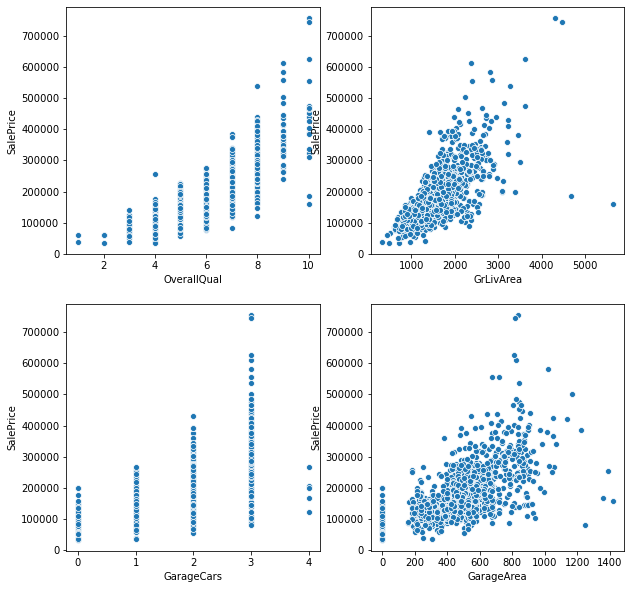

In [5]:
import matplotlib.pyplot as plt 
import seaborn as sns

_ , b = plt.subplots(2, 2, figsize=(10,10))

sns.scatterplot(train['OverallQual'],train['SalePrice'],ax=b[0][0])
sns.scatterplot(train['GrLivArea'],train['SalePrice'],ax=b[0][1])
sns.scatterplot(train['GarageCars'],train['SalePrice'],ax=b[1][0])
sns.scatterplot(train['GarageArea'],train['SalePrice'],ax=b[1][1])

#For문 어떻게 쓰는지 알아보기 plt.subplot 목록만 넣어주면 알아서 그려주는 거 있음 - 숙제!! 

In [6]:
train.dtypes

Id                 int64
MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
Street            object
Alley             object
LotShape          object
LandContour       object
Utilities         object
LotConfig         object
LandSlope         object
Neighborhood      object
Condition1        object
Condition2        object
BldgType          object
HouseStyle        object
OverallQual        int64
OverallCond        int64
YearBuilt          int64
YearRemodAdd       int64
RoofStyle         object
RoofMatl          object
Exterior1st       object
Exterior2nd       object
MasVnrType        object
MasVnrArea       float64
ExterQual         object
ExterCond         object
Foundation        object
BsmtQual          object
BsmtCond          object
BsmtExposure      object
BsmtFinType1      object
BsmtFinSF1         int64
BsmtFinType2      object
BsmtFinSF2         int64
BsmtUnfSF          int64
TotalBsmtSF        int64
Heating           object


In [7]:
train.corr()['SalePrice'].sort_values()
#0.3을 넘는 숫자적 성향 가진 변수가 흔하지 않음 (약한 상관관계 cutoff)
#숫자형 데이터에 대해서만 보이는 것 

KitchenAbvGr    -0.135907
EnclosedPorch   -0.128578
MSSubClass      -0.084284
OverallCond     -0.077856
YrSold          -0.028923
LowQualFinSF    -0.025606
Id              -0.021917
MiscVal         -0.021190
BsmtHalfBath    -0.016844
BsmtFinSF2      -0.011378
3SsnPorch        0.044584
MoSold           0.046432
PoolArea         0.092404
ScreenPorch      0.111447
BedroomAbvGr     0.168213
BsmtUnfSF        0.214479
BsmtFullBath     0.227122
LotArea          0.263843
HalfBath         0.284108
OpenPorchSF      0.315856
2ndFlrSF         0.319334
WoodDeckSF       0.324413
LotFrontage      0.351799
BsmtFinSF1       0.386420
Fireplaces       0.466929
MasVnrArea       0.477493
GarageYrBlt      0.486362
YearRemodAdd     0.507101
YearBuilt        0.522897
TotRmsAbvGrd     0.533723
FullBath         0.560664
1stFlrSF         0.605852
TotalBsmtSF      0.613581
GarageArea       0.623431
GarageCars       0.640409
GrLivArea        0.708624
OverallQual      0.790982
SalePrice        1.000000
Name: SalePr

# 1. 전처리

In [8]:
all_data2 = all_data.drop(columns=['SalePrice','Id'])

## * One Hot Encoding 선형모델에서만!!! Tree에선 쓰지마!

In [9]:
all_data3 = pd.get_dummies(all_data2)

In [10]:
all_data3

MSSubClass  LotFrontage  LotArea  OverallQual  OverallCond  YearBuilt  \
0             60         65.0     8450            7            5       2003   
1             20         80.0     9600            6            8       1976   
2             60         68.0    11250            7            5       2001   
3             70         60.0     9550            7            5       1915   
4             60         84.0    14260            8            5       2000   
...          ...          ...      ...          ...          ...        ...   
1454         160         21.0     1936            4            7       1970   
1455         160         21.0     1894            4            5       1970   
1456          20        160.0    20000            5            7       1960   
1457          85         62.0    10441            5            5       1992   
1458          60         74.0     9627            7            5       1993   

      YearRemodAdd  MasVnrArea  BsmtFinSF1  BsmtFinSF2  BsmtUnfSF  \
0             2003       196.0       706.0         0.0      150.0   
1             1976         0.0       978.0         0.0      284.0   
2             2002       162.0       486.0         0.0      434.0   
3             1970         0.0       216.0         0.0      540.0   
4             2000       350.0       655.0         0.0      490.0   
...            ...         ...         ...         ...        ...   
1454          1970         0.0         0.0         0.0      546.0   
1455          1970         0.0       252.0         0.0      294.0   
1456          1996         0.0      1224.0         0.0        0.0   
1457          1992         0.0       337.0         0.0      575.0   
1458          1994        94.0       758.0         0.0      238.0   

      TotalBsmtSF  1stFlrSF  2ndFlrSF  LowQualFinSF  GrLivArea  BsmtFullBath  \
0           856.0       856       854             0       1710           1.0   
1          1262.0      1262         0             0       1262           0.0   
2           920.0       920       866             0       1786           1.0   
3           756.0       961       756             0       1717           1.0   
4          1145.0      1145      1053             0       2198           1.0   
...           ...       ...       ...           ...        ...           ...   
1454        546.0       546       546             0       1092           0.0   
1455        546.0       546       546             0       1092           0.0   
1456       1224.0      1224         0             0       1224           1.0   
1457        912.0       970         0             0        970           0.0   
1458        996.0       996      1004             0       2000           0.0   

      BsmtHalfBath  FullBath  HalfBath  BedroomAbvGr  KitchenAbvGr  \
0              0.0         2         1             3             1   
1              1.0         2         0             3             1   
2              0.0         2         1             3             1   
3              0.0         1         0             3             1   
4              0.0         2         1             4             1   
...            ...       ...       ...           ...           ...   
1454           0.0         1         1             3             1   
1455           0.0         1         1             3             1   
1456           0.0         1         0             4             1   
1457           1.0         1         0             3             1   
1458           0.0         2         1             3             1   

      TotRmsAbvGrd  Fireplaces  GarageYrBlt  GarageCars  GarageArea  \
0                8           0       2003.0         2.0       548.0   
1                6           1       1976.0         2.0       460.0   
2                6           1       2001.0         2.0       608.0   
3                7           1       1998.0         3.0       642.0   
4                9           1       2000.0         3.0       836.0   


In [11]:
# Good Excellent 같은 Categorical 변수들은 숫자적인 느낌도 있음 (지하철 호선 처럼 <- 만들어진 순서)
# 1) One hot encoding + 2) Numerical 자체로 *Label Encoding하면 안되고 실제로 순서대로 지정해줘야 함  =>  두가지 방법 모두 사용함 

### 과대적합, 과소적합 문제는 Option에서 regularization으로 완화해줄 수 있음 

* ## Numerical Variables - 결측치 처리 (Mean)
-> 대회에서 값이 없어서 결측치라고 나와있기 때문에, 이 대회에서는 의미 없음 (그냥 -1로) 

In [12]:
all_data3.isnull().sum()

MSSubClass                 0
LotFrontage              486
LotArea                    0
OverallQual                0
OverallCond                0
YearBuilt                  0
YearRemodAdd               0
MasVnrArea                23
BsmtFinSF1                 1
BsmtFinSF2                 1
BsmtUnfSF                  1
TotalBsmtSF                1
1stFlrSF                   0
2ndFlrSF                   0
LowQualFinSF               0
GrLivArea                  0
BsmtFullBath               2
BsmtHalfBath               2
FullBath                   0
HalfBath                   0
BedroomAbvGr               0
KitchenAbvGr               0
TotRmsAbvGrd               0
Fireplaces                 0
GarageYrBlt              159
GarageCars                 1
GarageArea                 1
WoodDeckSF                 0
OpenPorchSF                0
EnclosedPorch              0
3SsnPorch                  0
ScreenPorch                0
PoolArea                   0
MiscVal                    0
MoSold        

In [13]:
null_list = ['LotFrontage','MasVnrArea','GarageYrBlt'] #numerical features 

In [14]:
for i in null_list:
    all_data3[i] = all_data3[i].replace(np.NaN,all_data3[i].mean())

In [15]:
all_data3.isnull().sum()

MSSubClass               0
LotFrontage              0
LotArea                  0
OverallQual              0
OverallCond              0
YearBuilt                0
YearRemodAdd             0
MasVnrArea               0
BsmtFinSF1               1
BsmtFinSF2               1
BsmtUnfSF                1
TotalBsmtSF              1
1stFlrSF                 0
2ndFlrSF                 0
LowQualFinSF             0
GrLivArea                0
BsmtFullBath             2
BsmtHalfBath             2
FullBath                 0
HalfBath                 0
BedroomAbvGr             0
KitchenAbvGr             0
TotRmsAbvGrd             0
Fireplaces               0
GarageYrBlt              0
GarageCars               1
GarageArea               1
WoodDeckSF               0
OpenPorchSF              0
EnclosedPorch            0
3SsnPorch                0
ScreenPorch              0
PoolArea                 0
MiscVal                  0
MoSold                   0
YrSold                   0
MSZoning_C (all)         0
M

* ## 나머지 결측치는 -1로 처리 

In [16]:
all_data3 = all_data3.fillna(-1)

In [17]:
all_data3.isnull().sum()

MSSubClass               0
LotFrontage              0
LotArea                  0
OverallQual              0
OverallCond              0
YearBuilt                0
YearRemodAdd             0
MasVnrArea               0
BsmtFinSF1               0
BsmtFinSF2               0
BsmtUnfSF                0
TotalBsmtSF              0
1stFlrSF                 0
2ndFlrSF                 0
LowQualFinSF             0
GrLivArea                0
BsmtFullBath             0
BsmtHalfBath             0
FullBath                 0
HalfBath                 0
BedroomAbvGr             0
KitchenAbvGr             0
TotRmsAbvGrd             0
Fireplaces               0
GarageYrBlt              0
GarageCars               0
GarageArea               0
WoodDeckSF               0
OpenPorchSF              0
EnclosedPorch            0
3SsnPorch                0
ScreenPorch              0
PoolArea                 0
MiscVal                  0
MoSold                   0
YrSold                   0
MSZoning_C (all)         0
M

In [18]:
all_data3.corr()

MSSubClass   LotFrontage   LotArea  OverallQual  \
MSSubClass               1.000000 -3.901181e-01 -0.201730     0.033638   
LotFrontage             -0.390118  1.000000e+00  0.364382     0.204190   
LotArea                 -0.201730  3.643820e-01  1.000000     0.100541   
OverallQual              0.033638  2.041895e-01  0.100541     1.000000   
OverallCond             -0.065625 -6.835001e-02 -0.035617    -0.093847   
YearBuilt                0.034409  1.169051e-01  0.024128     0.597554   
YearRemodAdd             0.043315  8.560757e-02  0.021612     0.571532   
MasVnrArea               0.005422  2.022101e-01  0.125354     0.430961   
BsmtFinSF1              -0.064001  2.031060e-01  0.194168     0.282151   
BsmtFinSF2              -0.072429  4.125309e-02  0.084108    -0.042602   
BsmtUnfSF               -0.125560  1.043314e-01  0.021590     0.275644   
TotalBsmtSF             -0.219007  3.295684e-01  0.254316     0.549763   
1stFlrSF                -0.248641  4.241467e-01  0.332460     0.479152   
2ndFlrSF                 0.309309  2.384233e-02  0.031515     0.245596   
LowQualFinSF             0.026482  4.669290e-03  0.000554    -0.048393   
GrLivArea                0.071677  3.494844e-01  0.284519     0.575126   
BsmtFullBath             0.011550  9.903280e-02  0.123685     0.166148   
BsmtHalfBath             0.000705 -2.863246e-02  0.019942    -0.037138   
FullBath                 0.139140  1.644689e-01  0.125826     0.528483   
HalfBath                 0.178750  3.557200e-02  0.034244     0.272668   
BedroomAbvGr            -0.008796  2.129429e-01  0.132801     0.073075   
KitchenAbvGr             0.260155  4.359164e-03 -0.020854    -0.159325   
TotRmsAbvGrd             0.040509  3.208628e-01  0.213802     0.389761   
Fireplaces              -0.055151  2.346122e-01  0.261185     0.390753   
GarageYrBlt              0.082790  7.039119e-02 -0.008564     0.544247   
GarageCars              -0.046867  2.925529e-01  0.180201     0.600288   
GarageArea              -0.103534  3.393804e-01  0.213180     0.565178   
WoodDeckSF              -0.017654  1.063796e-01  0.158045     0.255317   
OpenPorchSF             -0.015923  1.521602e-01  0.104797     0.298084   
EnclosedPorch           -0.020867  1.054129e-02  0.020974    -0.139256   
3SsnPorch               -0.037529  2.525492e-02  0.015995     0.018715   
ScreenPorch             -0.049181  6.934757e-02  0.054375     0.042910   
PoolArea                -0.003080  1.608573e-01  0.093708     0.030740   
MiscVal                 -0.028867  3.576182e-02  0.069029     0.005562   
MoSold                  -0.001231  1.033721e-02  0.004156     0.030405   
YrSold                  -0.015028 -7.264511e-03 -0.024234    -0.019614   
MSZoning_C (all)         0.006258 -1.483587e-02 -0.021774    -0.143010   
MSZoning_FV              0.169452 -8.782912e-02 -0.102614     0.186713   
MSZoning_RH              0.072856 -5.459065e-02 -0.031998    -0.049960   
MSZoning_RL             -0.339530  3.365634e-01  0.236318     0.141194   
MSZoning_RM              0.271093 -3.206684e-01 -0.206661    -0.211415   
Street_Grvl             -0.001971  4.747431e-02  0.133936    -0.072424   
Street_Pave              0.001971 -4.747431e-02 -0.133936     0.072424   
Alley_Grvl               0.040730 -8.671297e-02 -0.040619    -0.139154   
Alley_Pave               0.183808 -1.684507e-01 -0.093570     0.060356   
LotShape_IR1            -0.085661  1.298051e-01  0.129776     0.240944   
LotShape_IR2            -0.013536 -9.053879e-03  0.181317     0.069025   
LotShape_IR3             0.003907  1.157642e-01  0.206142     0.038098   
LotShape_Reg             0.087743 -1.418517e-01 -0.218736    -0.264585   
LandContour_Bnk          0.013759  1.779530e-02  0.031329    -0.067424   
LandContour_HLS          0.002373  3.778848e-02  0.057587     0.158276   
LandContour_Low         -0.041647  3.885429e-02  0.306076    -0.039982   
LandContour_Lvl          0.009061 -5.459950e-02 -0.201801    -0.041435   
Utilities_AllPub         0.

### 표준화 / 스케일링 해줘서 컬럼들이 어느정도 비슷해지도록 처리해주기 (Standardization) - Tree는 어차피 기준점을 사용하니까 필요없음

### 1) Min Max 
### 2) Standard Scaler
### 3) Log Scaling 
... and more

질문: 세가지 중 선택하는 기준? 

* ## 1) Min Max Scaling

In [19]:
#from sklearn.preprocessing import MinMaxScaler
#mm = MinMaxScaler()
#all_data4 = mm.fit_transform(all_data4)
#all_data4 = pd.DataFrame(all_data4)

* ## 2) Standard Scaling 

In [20]:
#from sklearn.preprocessing import StandardScaler
#ss = StandardScaler()
#all_data4 = ss.fit_transform(all_data3)


In [21]:
#all_data4 = pd.DataFrame(all_data4, columns=all_data3.columns)
#all_data4
#shift + tab*5 -> 옵션확인

* ## 3) Log Transformation and replacing NaN with mean value 

In [22]:
for i in all_data3.columns:
        if all_data3[i].dtype in ['int64', 'float64']:
            if all_data3[i].all() > 0:
                all_data3[i] = np.log10(all_data[i])
                all_data3[i] = all_data3[i].replace(np.NaN,all_data3[i].mean())
                print(all_data3[i])
            
            
all_data4 = all_data3

0       1.778151
1       1.301030
2       1.778151
3       1.845098
4       1.778151
          ...   
1454    2.204120
1455    2.204120
1456    1.301030
1457    1.929419
1458    1.778151
Name: MSSubClass, Length: 2919, dtype: float64
0       1.812913
1       1.903090
2       1.832509
3       1.778151
4       1.924279
          ...   
1454    1.322219
1455    1.322219
1456    2.204120
1457    1.792392
1458    1.869232
Name: LotFrontage, Length: 2919, dtype: float64
0       3.926857
1       3.982271
2       4.051153
3       3.980003
4       4.154120
          ...   
1454    3.286905
1455    3.277380
1456    4.301030
1457    4.018742
1458    3.983491
Name: LotArea, Length: 2919, dtype: float64
0       0.845098
1       0.778151
2       0.845098
3       0.845098
4       0.903090
          ...   
1454    0.602060
1455    0.602060
1456    0.698970
1457    0.698970
1458    0.845098
Name: OverallQual, Length: 2919, dtype: float64
0       0.698970
1       0.903090
2       0.698970
3       0.6989

In [23]:
train2 = all_data4[:len(train)]
test2 = all_data4[len(train):]

* ## Lasso / Ridge 모델 학습 

* ## Alpha값 고르기 

In [24]:
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score
#score = np.sqrt(-cross_val_score(r,train2,train['SalePrice'],n_jobs=-1,cv=10,scoring='neg_mean_squared_error').mean()) #-가 붙어서 MSE 대신 Negative붙임 
#score

for i in [1, 10, 20, 30, 50, 100, 200, 300, 500,700, 1000]:
    r = Lasso(alpha=i)
    r.fit(train2, train['SalePrice'])
    result = r.predict(test2)
    score = np.sqrt(-cross_val_score(r,train2,train['SalePrice'],n_jobs=-1,cv=10,scoring='neg_mean_squared_error').mean()) #-가 붙어서 MSE 대신 Negative붙임 
    print(score)

#질문
#Alpha: Lambda값? 
#CV: Fold 값? 

#Lasso: 값의 가중치 자체를 0으로 보내버릴 수 있음 
    

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 325564484973.9028, tolerance: 920791133.4609975
  positive)


35698.673357648724
34183.0098052051
33315.46783939429
32487.880060126274
31670.43815509456
30904.42370717901
31222.508196590763
32361.945145606354
34693.94686539394
36660.56721888859
37758.77915946642


* ## 1) Ridge Model 

In [25]:
# 모델들에 다중공산성 문제를 해결해줄 수 있는 옵션이 들어가있음 

In [26]:
#LinearRegression단점: 모든 컬럼을 다 중요하게 생각하고, 규제를 주지 않아서 과대적합 발생할 수 있음
#LogisticRegression은 분류할 때 
#Lasso, Ridge, 모델  중에서 사용하면 됨 - 공부하기!

#L2규제: 가중치가 0 가까이 변해서 학습을 거의 하지 않음 
#L1규제: 도움 안되면 아예 제외해버림

#r = Lasso(alpha=100)
#r.fit(train2,train['SalePrice'])
#result = r.predict(test2) 

#Validation방법
#1) Validation비율 지정해주기
    #a. 일부 데이터 뽑으면 Test set의 분포를 잘 반영 못할 수도 있음 (-)
    #b. 학습할 데이터가 부족해짐 (-)
#2) 교차검정-K-Fold/Cross Validation

* ## 2) Lasso Model

In [27]:

#LinearRegression단점: 모든 컬럼을 다 중요하게 생각하고, 규제를 주지 않아서 과대적합 발생할 수 있음
#LogisticRegression은 분류할 때 
#Lasso, Ridge, 모델  중에서 사용하면 됨 - 공부하기!

#L2규제: 가중치가 0 가까이 변해서 학습을 거의 하지 않음 
#L1규제: 도움 안되면 아예 제외해버림

r = Lasso(alpha=100)
r.fit(train2,train['SalePrice'])
result = r.predict(test2) 

#Validation방법
#1) Validation비율 지정해주기
    #a. 일부 데이터 뽑으면 Test set의 분포를 잘 반영 못할 수도 있음 (-)
    #b. 학습할 데이터가 부족해짐 (-)
#2) 교차검정-K-Fold/Cross Validation

In [28]:
sub = pd.read_csv('/kaggle/input/home-data-for-ml-course/sample_submission.csv')

In [29]:
sub

Id      SalePrice
0     1461  169277.052498
1     1462  187758.393989
2     1463  183583.683570
3     1464  179317.477511
4     1465  150730.079977
...    ...            ...
1454  2915  167081.220949
1455  2916  164788.778231
1456  2917  219222.423400
1457  2918  184924.279659
1458  2919  187741.866657

[1459 rows x 2 columns]

In [30]:
sub['SalePrice'] = result

In [31]:
sub.to_csv('submission.csv', index=False)